# Preprocessing and first models

After the EDA, we prepare the data in order to create the first models and evaluate them.

Organization : 
* data preparation : we summarize some steps from the EDA
* train set / validation set 
* preprocessing (basic) : we create some functions for encoding object variables and dealing with missing data
* models : we create the models we use
* evaluation : we create functions in order to train and evaluate the models
* different attempts : 
    * here we list our different approches in order to compare them more easily
    * we modify some functions from the basic preprocessing part, and we create some new ones.
    

In [1]:
# libraries

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train set / test set
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import KNNImputer

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# evaluation
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [2]:
# options
pd.options.display.max_columns=120

# <font color='#CB6318'><u>Data preparation</u></font>

After our EDA, we summarize the data transformations steps :
* start with the train_set
* keep columns with < 90% of NaN
* delete 'Patient ID'
* delete 'Parainfluenza 2'
* delete Patient admission columns.

groups created :
* positive_covid / negative_covid
* blood_columns / virus_columns

new features :
* 'virus_detected' : we don't use it at the beginning, but later.

In [3]:
covid = pd.read_csv('train_set_covid_diagnosis.csv', header=0, index_col=0)

In [4]:
covid = covid[covid.columns[covid.isnull().sum()/len(covid) < 0.9]] 

In [5]:
covid = covid.drop('Patient ID',axis=1)

In [6]:
covid = covid.drop('Parainfluenza 2',axis=1)

In [7]:
covid = covid.drop(['Patient addmited to regular ward (1=yes, 0=no)',
                    'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                    'Patient addmited to intensive care unit (1=yes, 0=no)'], axis=1)
covid

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,"Influenza B, rapid test","Influenza A, rapid test"
2045,9,negative,-0.63325,-0.6489,0.19861,0.347255,-1.008708,-0.236022,-0.253742,0.473079,-0.834685,0.805435,-0.456253,0.987404,-0.482876,-0.713529,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2719,3,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749,14,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
3108,14,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,3,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
5192,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3980,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,16,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


In [8]:
target='SARS-Cov-2 exam result'
positive_covid = covid[covid[target]=='positive']
negative_covid = covid[covid[target]=='negative']

In [9]:
missing_rate = covid.isnull().sum()/len(covid)
blood_columns = covid.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
virus_columns = covid.columns[(missing_rate < 0.86) & (missing_rate > 0.75)]

# <font color='#CB6318'><u>Train set / Validation set</u></font>

In [10]:
trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

We check that the target proportions are the same : 

In [11]:
target = 'SARS-Cov-2 exam result'
print(trainset[target].value_counts())
print()
print(trainset[target].value_counts()/len(trainset))

negative    3043
positive     343
Name: SARS-Cov-2 exam result, dtype: int64

negative    0.898701
positive    0.101299
Name: SARS-Cov-2 exam result, dtype: float64


In [12]:
print(validset[target].value_counts())
print()
print(validset[target].value_counts()/len(validset))

negative    1021
positive     108
Name: SARS-Cov-2 exam result, dtype: int64

negative    0.90434
positive    0.09566
Name: SARS-Cov-2 exam result, dtype: float64


# <font color='#CB6318'><u>Preprocessing</u></font>

In [13]:
# encoding object variables

def encoding(df):
    # encoding dictionary
    code = {'positive':1,
            'negative':0,
            'detected':1,
            'not_detected':0}
    
    # apply map funtion on each object column
    for col in df.select_dtypes('object'):
        df.loc[:,col] = df[col].map(code)
        
    return df

In [14]:
# missing data

# deletion lines with NaN or imputation
def missing_data(df, action, value=-999):             # action : 'drop_na' or 'imputation'
    if action=='drop_na':
        return df.dropna(axis=0)
    else:
        return df.fillna(value)    

In [15]:
# basic preprocessing : encoding + missing data + create dataframes X(without target) and y(target)

def preprocessing_basic(df, action_missing_data, value=-999):      # action : 'drop_na' or 'imputation'
    df = encoding(df)
    df = missing_data(df, action_missing_data,value)
    
    X=df.drop(target, axis=1)
    y=df[target]
    
    #check target proportions after preprocessing
    print(y.value_counts())
    print()
    print(y.value_counts()/len(y))
    print()
    
    return X,y

# <font color='#CB6318'><u>Models</u></font>

In [16]:
model_tree = DecisionTreeClassifier(random_state=0)
model_forest = RandomForestClassifier(random_state=0)
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=5), RandomForestClassifier(random_state=0))

# <font color='#CB6318'><u>Evaluation</u></font>

* confusion matrix
* classification_report : precision, recall, f1-score
* learning curves : scoring='f1'

In [17]:
def evaluation(model,X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    print(confusion_matrix(y_val, y_pred))
    print()
    print(classification_report(y_val, y_pred))
    print()

    
    # learning curves
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=4, 
                                              train_sizes=np.linspace(0.1,1,10),
                                              scoring='f1')
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.xlabel('N (train_sizes)')
    plt.ylabel('f1')
    plt.legend()

# <font color='#CB6318'><u>Different attempts</u></font>

Steps to repeat :
* create trainset and validset (because they are modified at each attempt)
* preprocessing
* model : precise which one is used
* training + evaluation   

Then :
* analysis 
* other choices.

In [18]:
# we create a function for these repeating steps

# arguments
    # model 
    # action_missing_data : 'drop_na' or 'imputation' 
    # value=-999 by default for the imputation


def attempt(model, action_missing_data, value=-999):
    
    # create train set/validation set
    trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)
    
    # preprocessing (basic)
    X_train, y_train = preprocessing_basic(trainset, action_missing_data, value)
    X_val, y_val = preprocessing_basic(validset, action_missing_data, value)
    
    # training + evaluation
    evaluation(model, X_train, y_train, X_val, y_val)

## <font color='#7CAA2D'><u>1st attempt</u></font>

* preprocessing : .dropna()
* model : DecisionTreeClassifier()
* evaluation : 
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    60
1     7
Name: SARS-Cov-2 exam result, dtype: int64

0    0.895522
1    0.104478
Name: SARS-Cov-2 exam result, dtype: float64

0    13
1     4
Name: SARS-Cov-2 exam result, dtype: int64

0    0.764706
1    0.235294
Name: SARS-Cov-2 exam result, dtype: float64

[[12  1]
 [ 3  1]]

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.50      0.25      0.33         4

    accuracy                           0.76        17
   macro avg       0.65      0.59      0.60        17
weighted avg       0.73      0.76      0.73        17




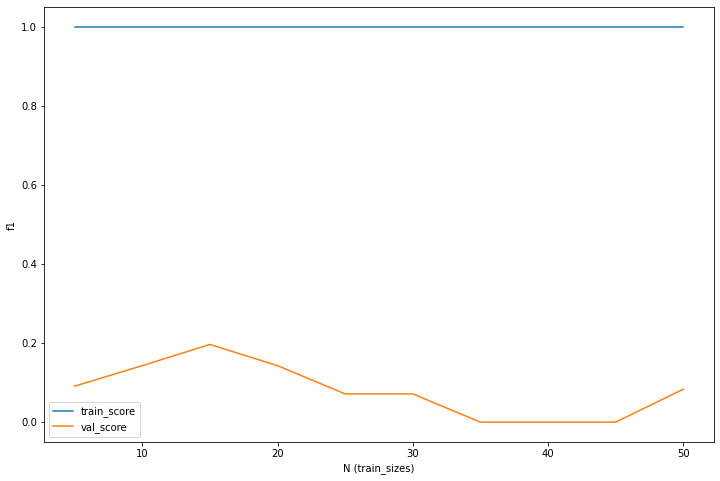

In [19]:
attempt(model_tree, 'drop_na')

Analysis :  
* there are not a lot of values after preprocessing
* y_val (validation target) proportions are not the same
* the model is overfitting (train_score 1, val_score <0.2).

## <font color='#7CAA2D'><u>2d attempt</u></font>

* preprocessing : .fillna(), with an extreme value -999
* model : DecisionTreeClassifier()
* evaluation : 
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    3043
1     343
Name: SARS-Cov-2 exam result, dtype: int64

0    0.898701
1    0.101299
Name: SARS-Cov-2 exam result, dtype: float64

0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64

0    0.90434
1    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1005   16]
 [ 102    6]]

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1021
           1       0.27      0.06      0.09       108

    accuracy                           0.90      1129
   macro avg       0.59      0.52      0.52      1129
weighted avg       0.85      0.90      0.86      1129




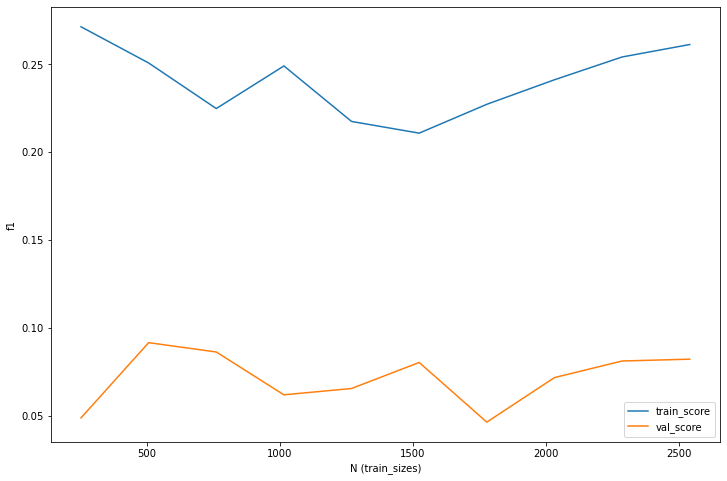

In [20]:
attempt(model_tree, 'imputation')

Analysis :  
* the number of values is better
* y_val proportions are now the same
* the 1-recall is really bad (6%), despite the 90% accuracy
* the scores are worse : 
    * we still have overfitting
    * moreover, 
        * it's not good even on the training set
        * val_score is worse (<0.1).
        
Other choices :  
* check with different imputation values : nothing really change on the learning curves 
* add a column 'is na' indicating some NaN :

In [21]:
# 1st choice : 
# we construct this new column by using for example 'Platelets' and 'Leukocytes' (2 variables correlated to the target) : 
# column 'is na' : True if a least one is True

# modify the 'missing_data' function
def missing_data(df, action, value=-999):             # action : 'drop_na' or 'create_boolean_column'
    if action=='drop_na':
        return df.dropna(axis=0)
    else:
        df['is na'] = df['Platelets'].isna() | df['Leukocytes'].isna()
        return df.fillna(value)

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-21-2e676bb8f623>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is na'] = df['Platelets'].isna() | df['Leukocytes'].isna()


0    3043
1     343
Name: SARS-Cov-2 exam result, dtype: int64

0    0.898701
1    0.101299
Name: SARS-Cov-2 exam result, dtype: float64

0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64

0    0.90434
1    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1006   15]
 [ 101    7]]

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1021
           1       0.32      0.06      0.11       108

    accuracy                           0.90      1129
   macro avg       0.61      0.53      0.53      1129
weighted avg       0.85      0.90      0.87      1129




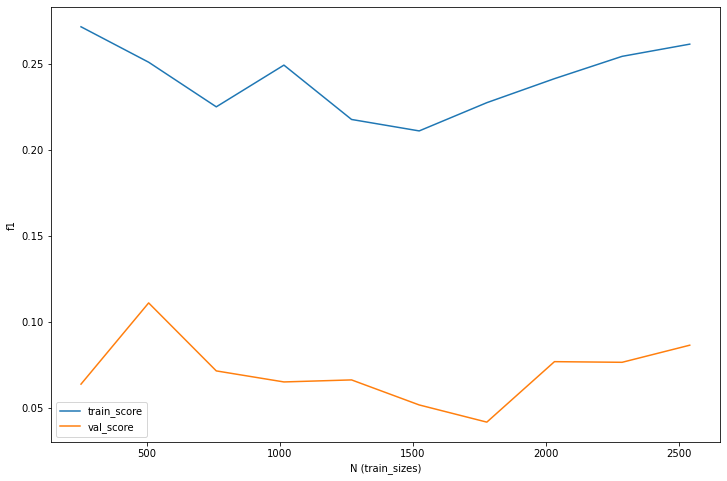

In [22]:
attempt(model_tree, 'create_boolean_column')

Analysis : there is no real improvement.

In [23]:
# 2d choice : 
# we construct this new column by using all the columns : True if at least one column has a NaN

def missing_data(df, action, value=-999):             # action : 'drop_na' or 'create_boolean_column'
    if action=='drop_na':
        return df.dropna(axis=0)
    else:
        df['is na'] = df.isnull().sum(axis=1) >= 1
        return df.fillna(value)

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-23-09db2c5d2057>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is na'] = df.isnull().sum(axis=1) >= 1
C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

0    3043
1     343
Name: SARS-Cov-2 exam result, dtype: int64

0    0.898701
1    0.101299
Name: SARS-Cov-2 exam result, dtype: float64

0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64

0    0.90434
1    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1007   14]
 [ 101    7]]

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1021
           1       0.33      0.06      0.11       108

    accuracy                           0.90      1129
   macro avg       0.62      0.53      0.53      1129
weighted avg       0.85      0.90      0.87      1129




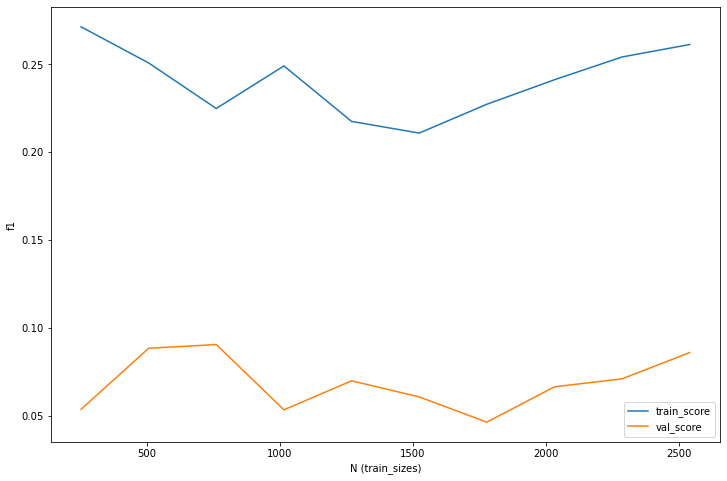

In [24]:
attempt(model_tree, 'create_boolean_column')

Analysis : there is no real improvement.

In [25]:
# go back to the previous version of the function
def missing_data(df, action, value=-999):             # action : 'drop_na' or 'imputation'
    if action=='drop_na':
        return df.dropna(axis=0)
    else:
        return df.fillna(value)  

## <font color='#7CAA2D'><u>3d attempt (features selection)</u></font>

* preprocessing : 
    * go back to .dropna()
    * features selection + .dropna()
* model : DecisionTreeClassifier
* evaluation : 
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

In [26]:
# we will need X_train, which is a local variable in the function 'attempt', 
# so we modify this function slightly in order to return X_train 

def attempt(model, action_missing_data, value=-999):
    trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)
    
    X_train, y_train = preprocessing_basic(trainset, action_missing_data, value)
    X_val, y_val = preprocessing_basic(validset, action_missing_data, value)

    evaluation(model,X_train,y_train,X_val,y_val)

    return X_train

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    60
1     7
Name: SARS-Cov-2 exam result, dtype: int64

0    0.895522
1    0.104478
Name: SARS-Cov-2 exam result, dtype: float64

0    13
1     4
Name: SARS-Cov-2 exam result, dtype: int64

0    0.764706
1    0.235294
Name: SARS-Cov-2 exam result, dtype: float64

[[12  1]
 [ 3  1]]

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.50      0.25      0.33         4

    accuracy                           0.76        17
   macro avg       0.65      0.59      0.60        17
weighted avg       0.73      0.76      0.73        17




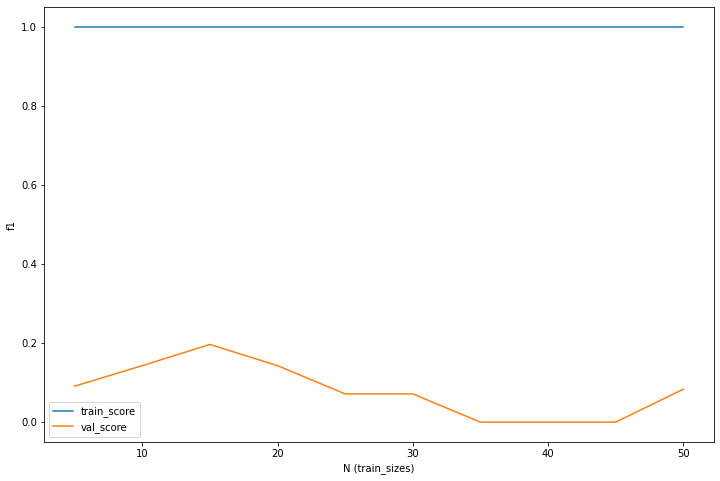

In [27]:
X_train = attempt(model_tree, 'drop_na')

<AxesSubplot:>

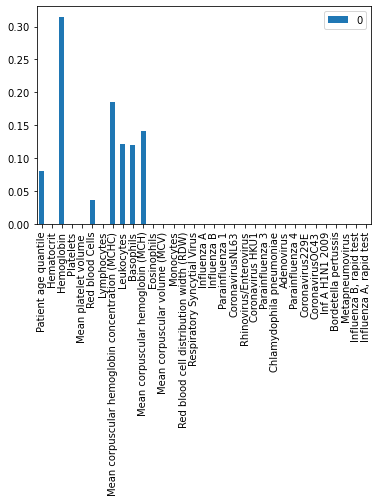

In [28]:
pd.DataFrame(model_tree.feature_importances_, index=X_train.columns).plot.bar()

* Let's remember that we don't have a lot of data here after .dropna().
* The virus features seem to be useless : so let's get rid of these columns.

0    325
1     45
Name: SARS-Cov-2 exam result, dtype: int64

0    0.878378
1    0.121622
Name: SARS-Cov-2 exam result, dtype: float64

0    102
1     15
Name: SARS-Cov-2 exam result, dtype: int64

0    0.871795
1    0.128205
Name: SARS-Cov-2 exam result, dtype: float64

[[89 13]
 [ 8  7]]

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       102
           1       0.35      0.47      0.40        15

    accuracy                           0.82       117
   macro avg       0.63      0.67      0.65       117
weighted avg       0.84      0.82      0.83       117




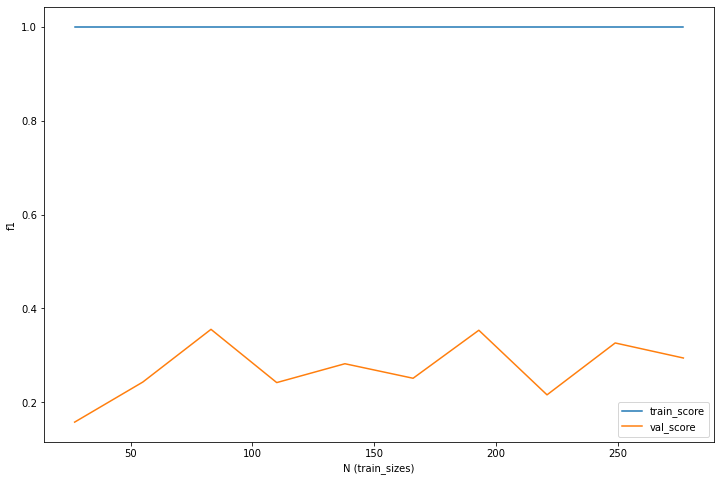

In [29]:
trainset, validset = train_test_split(covid.drop(virus_columns,axis=1), test_size=0.25, random_state=0)
    
X_train, y_train = preprocessing_basic(trainset, 'drop_na')
X_val, y_val = preprocessing_basic(validset, 'drop_na')

evaluation(model_tree,X_train,y_train,X_val,y_val)    

Analysis : 
* as expected, we have this time more data after .dropna() 
* the model is still overfitting
* the val_score is very slightly better. 

## <font color='#7CAA2D'><u>4th attempt (new model)</u></font>

* preprocessing : 
    * .dropna()
    * imputation with an extreme value =999
    * drop the virus columns + .dropna()
    * drop the virus columns + KNNImputer
* model : RandomForest()
* evaluation :
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

<u>1st preprocessing choice (.dropna())</u>

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    60
1     7
Name: SARS-Cov-2 exam result, dtype: int64

0    0.895522
1    0.104478
Name: SARS-Cov-2 exam result, dtype: float64

0    13
1     4
Name: SARS-Cov-2 exam result, dtype: int64

0    0.764706
1    0.235294
Name: SARS-Cov-2 exam result, dtype: float64

[[13  0]
 [ 4  0]]

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.00      0.00      0.00         4

    accuracy                           0.76        17
   macro avg       0.38      0.50      0.43        17
weighted avg       0.58      0.76      0.66        17




C:\Users\dataa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


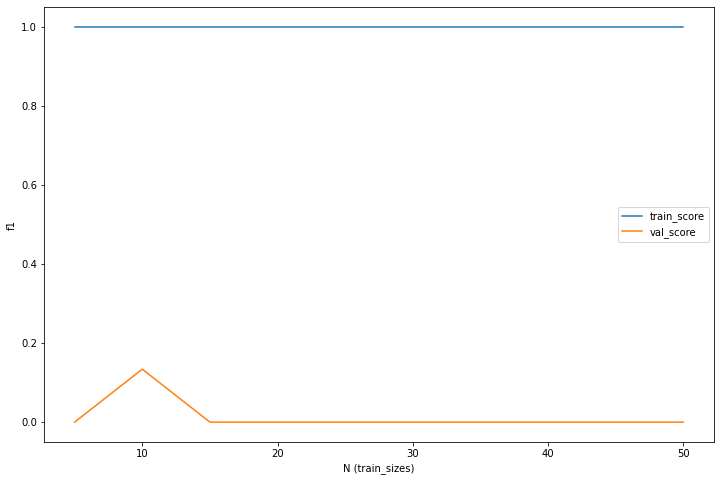

In [30]:
X_train = attempt(model_forest, 'drop_na')

Analysis : the model is really not good. 

<AxesSubplot:>

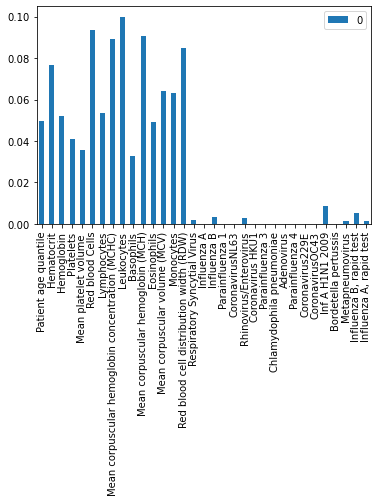

In [31]:
pd.DataFrame(model_forest.feature_importances_, index=X_train.columns).plot.bar()

<u>2d preprocessing choice (imputation)</u>

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    3043
1     343
Name: SARS-Cov-2 exam result, dtype: int64

0    0.898701
1    0.101299
Name: SARS-Cov-2 exam result, dtype: float64

0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64

0    0.90434
1    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1017    4]
 [ 108    0]]

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1021
           1       0.00      0.00      0.00       108

    accuracy                           0.90      1129
   macro avg       0.45      0.50      0.47      1129
weighted avg       0.82      0.90      0.86      1129




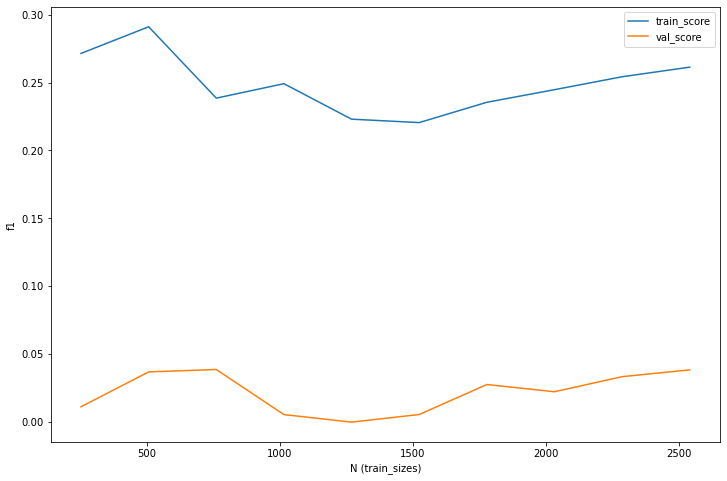

In [32]:
X_train = attempt(model_forest, 'imputation')

Analysis : this model is worse at all levels. 

<u>3d preprocessing choice (drop virus columns + .dropna())</u> 

0    325
1     45
Name: SARS-Cov-2 exam result, dtype: int64

0    0.878378
1    0.121622
Name: SARS-Cov-2 exam result, dtype: float64

0    102
1     15
Name: SARS-Cov-2 exam result, dtype: int64

0    0.871795
1    0.128205
Name: SARS-Cov-2 exam result, dtype: float64

[[100   2]
 [ 14   1]]

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       102
           1       0.33      0.07      0.11        15

    accuracy                           0.86       117
   macro avg       0.61      0.52      0.52       117
weighted avg       0.81      0.86      0.82       117




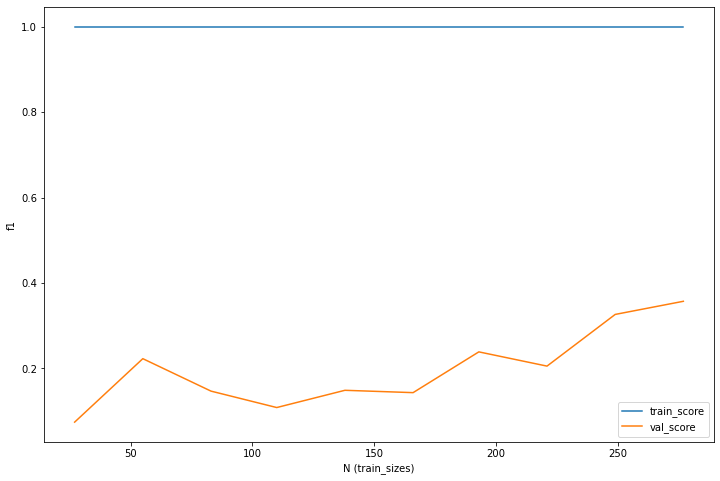

In [33]:
trainset, validset = train_test_split(covid.drop(virus_columns,axis=1), test_size=0.25, random_state=0)
    
X_train, y_train = preprocessing_basic(trainset, 'drop_na')
X_val, y_val = preprocessing_basic(validset, 'drop_na')

evaluation(model_forest,X_train,y_train,X_val,y_val)   

<AxesSubplot:>

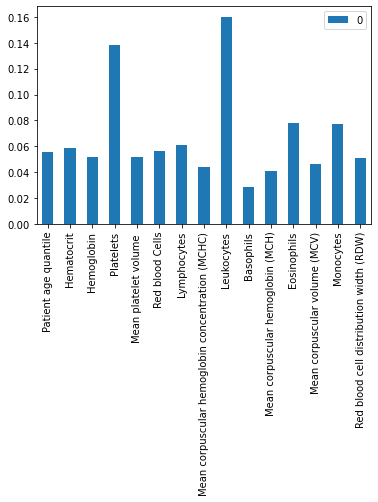

In [34]:
pd.DataFrame(model_forest.feature_importances_, index=X_train.columns).plot.bar()

Analysis : 
* it's still not good, but the val_score seems to increase with N , maybe it could improve with more data
* 'Platelets' and 'Leukocytes' are two main features, which is consistent with what we suspected in the EDA. 

<u>4th preprocessing choice (drop virus columns + KNNImputer())</u>

In [35]:
# we modify the 'preprocessing_basic' function, by replacing the 'missing_data' function by scikit-learn KNNImputer
# we make 2 versions : one for trainset, with .fit_transform(), another one with .transform for validset (with the same imputer)

def preprocessing_knnimputer_train(df):      
    df = encoding(df)
    
    imputer = KNNImputer(n_neighbors=1)
    df_imputed = imputer.fit_transform(df)  # array => transform to a dataframe 
                                            # need to keep index and columns names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    X=df_imputed.drop(target, axis=1)
    y=df_imputed[target]
    
    #check target proportions after preprocessing
    print(y.value_counts())
    print()
    print(y.value_counts()/len(y))
    print()
    
    return X,y, imputer

def preprocessing_knnimputer_valid(df):      
    df = encoding(df)
    
    df_imputed = imputer.transform(df)  # array => transform to a dataframe 
                                        # need to keep index and columns names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    X=df_imputed.drop(target, axis=1)
    y=df_imputed[target]
    
    #check target proportions after preprocessing
    print(y.value_counts())
    print()
    print(y.value_counts()/len(y))
    print()
    
    return X,y

0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64

0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1017    4]
 [  14   94]]

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1021
         1.0       0.96      0.87      0.91       108

    accuracy                           0.98      1129
   macro avg       0.97      0.93      0.95      1129
weighted avg       0.98      0.98      0.98      1129




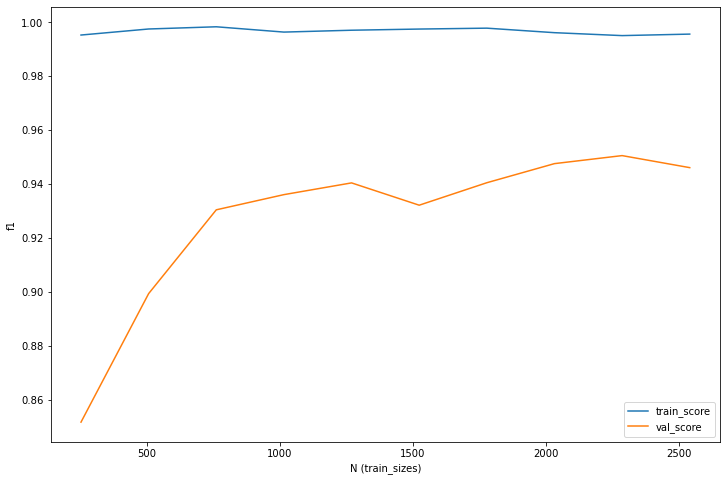

In [36]:
trainset, validset = train_test_split(covid.drop(virus_columns, axis=1), test_size=0.25, random_state=0)
    
X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest,X_train,y_train,X_val,y_val)   

Analysis : 
* the val_score has increased significantly !
* the 1-precision, 1-recall, f1-score are pretty good !
* we still have some overfitting.

<AxesSubplot:>

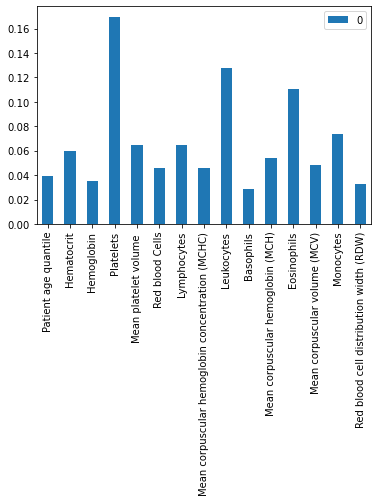

In [37]:
pd.DataFrame(model_forest.feature_importances_, index=X_train.columns).plot.bar()

## <font color='#7CAA2D'><u>5th attempt (feature engineering)</u></font>

* preprocessing : 
    * add a new feature 'virus_detected' + drop virus columns (except the new one) + KNNImputer()
* model : RandomForest (we try to improve the previous model)
* evaluation :
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

In [38]:
# new preprocessing function : add a new feature 'virus_detected' + drop virus columns (except the new one)

def feature_engineering(df):
    df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1
    df = df.drop(virus_columns, axis=1)
    return df

In [39]:
# modify 'preprocessing_knnimputer' functions : include the 'feature_engineering' function

def preprocessing_knnimputer_train(df):      
    df = encoding(df)
    
    df = feature_engineering(df)
    
    imputer = KNNImputer(n_neighbors=1)
    df_imputed = imputer.fit_transform(df)  # array => transform to a dataframe 
                                            # need to keep index and columns names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    X=df_imputed.drop(target, axis=1)
    y=df_imputed[target]
    
    #check target proportions after preprocessing
    print(y.value_counts())
    print()
    print(y.value_counts()/len(y))
    print()
    
    return X,y, imputer

def preprocessing_knnimputer_valid(df):      
    df = encoding(df)
    
    df = feature_engineering(df)

    df_imputed = imputer.transform(df)  # array => transform to a dataframe 
                                        # need to keep index and columns names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    X=df_imputed.drop(target, axis=1)
    y=df_imputed[target]
    
    #check target proportions after preprocessing
    print(y.value_counts())
    print()
    print(y.value_counts()/len(y))
    print()
    
    return X,y

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1015    6]
 [  12   96]]

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1021
         1.0       0.94      0.89      0.91       108

    accuracy                           0.98      1129
   macro avg       0.96      0.94      0.95      1129
weighted avg       0.98      0.98      0.98      1129




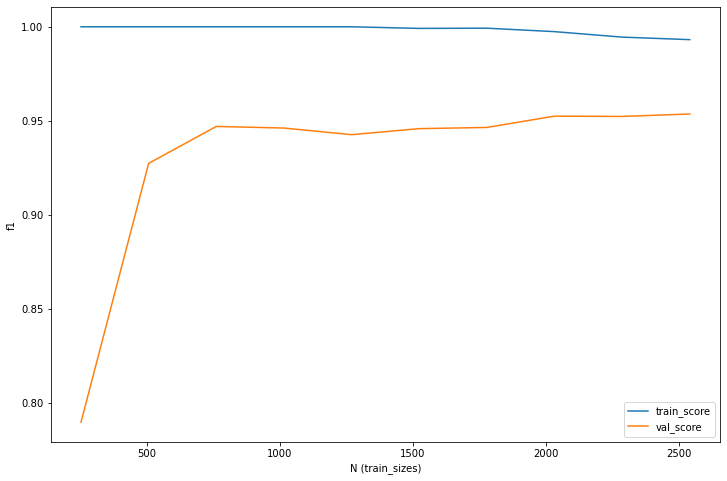

In [40]:
trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)
    
X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest,X_train,y_train,X_val,y_val) 

<AxesSubplot:>

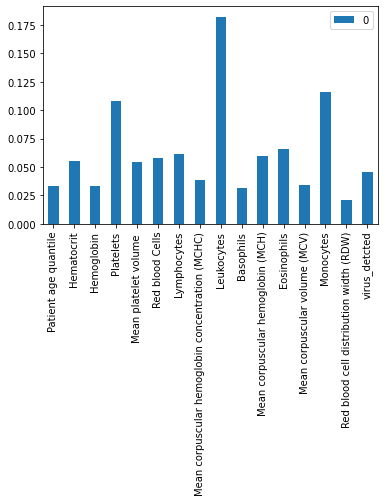

In [41]:
pd.DataFrame(model_forest.feature_importances_, index=X_train.columns).plot.bar()

Analysis : 
* there is no real improvement
* it seems that there is a kind of cap after N=800.

## <font color='#7CAA2D'><u>6th attempt (features selection)</u></font>

* preprocessing and model :
    * same preprocesing functions
    * make_pipeline + SelectKBest + RandomForest 
* evaluation : idem

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1007   14]
 [  37   71]]

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      1021
         1.0       0.84      0.66      0.74       108

    accuracy                           0.95      1129
   macro avg       0.90      0.82      0.86      1129
weighted avg       0.95      0.95      0.95      1129




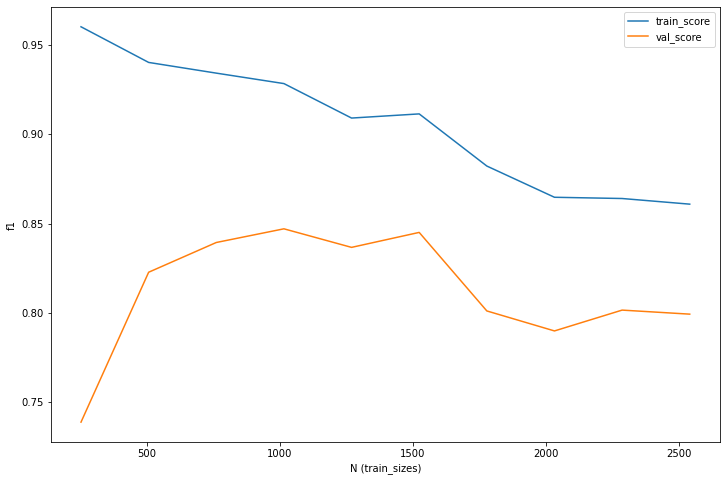

In [42]:
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=1), RandomForestClassifier(random_state=0))

trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest_pipeline,X_train,y_train,X_val,y_val) 

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1007   14]
 [  11   97]]

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1021
         1.0       0.87      0.90      0.89       108

    accuracy                           0.98      1129
   macro avg       0.93      0.94      0.94      1129
weighted avg       0.98      0.98      0.98      1129




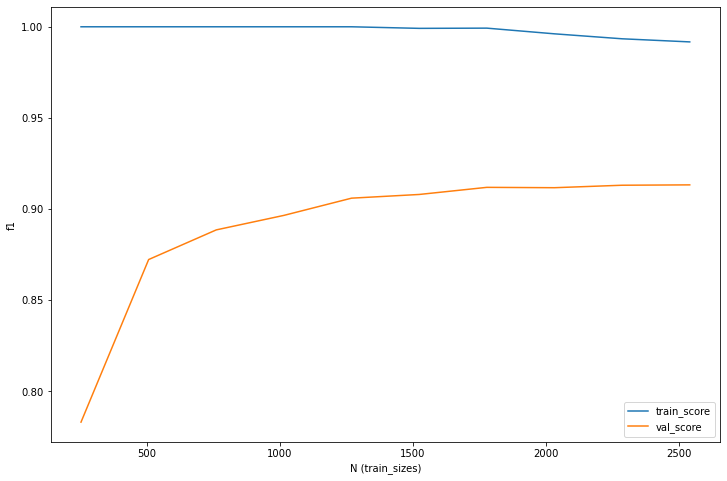

In [43]:
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=2), RandomForestClassifier(random_state=0))

trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest_pipeline,X_train,y_train,X_val,y_val) 

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1013    8]
 [  10   98]]

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1021
         1.0       0.92      0.91      0.92       108

    accuracy                           0.98      1129
   macro avg       0.96      0.95      0.95      1129
weighted avg       0.98      0.98      0.98      1129




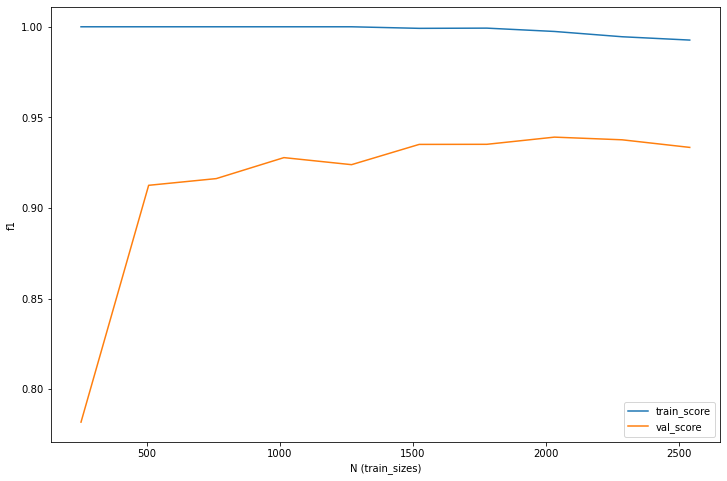

In [44]:
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=3), RandomForestClassifier(random_state=0))

trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest_pipeline,X_train,y_train,X_val,y_val) 

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1013    8]
 [  11   97]]

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1021
         1.0       0.92      0.90      0.91       108

    accuracy                           0.98      1129
   macro avg       0.96      0.95      0.95      1129
weighted avg       0.98      0.98      0.98      1129




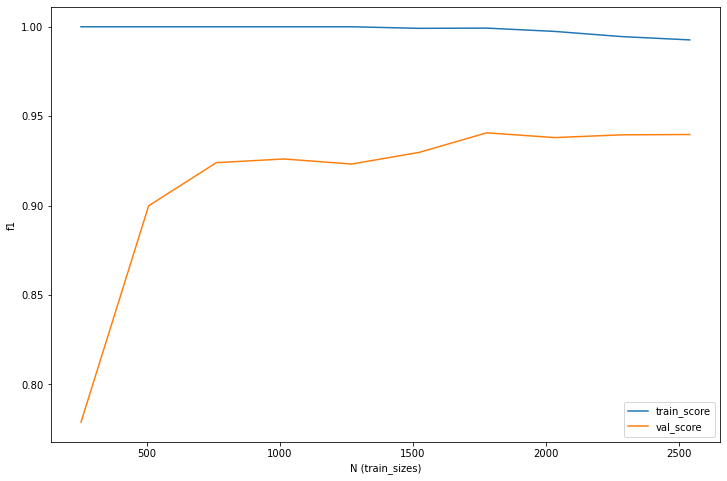

In [45]:
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=4), RandomForestClassifier(random_state=0))

trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest_pipeline,X_train,y_train,X_val,y_val) 

C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    3043
1.0     343
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.898701
1.0    0.101299
Name: SARS-Cov-2 exam result, dtype: float64



C:\Users\dataa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-38-ce84e08cee3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['virus_detcted'] = df[virus_columns].sum(axis=1) >= 1


0.0    1021
1.0     108
Name: SARS-Cov-2 exam result, dtype: int64

0.0    0.90434
1.0    0.09566
Name: SARS-Cov-2 exam result, dtype: float64

[[1013    8]
 [  11   97]]

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1021
         1.0       0.92      0.90      0.91       108

    accuracy                           0.98      1129
   macro avg       0.96      0.95      0.95      1129
weighted avg       0.98      0.98      0.98      1129




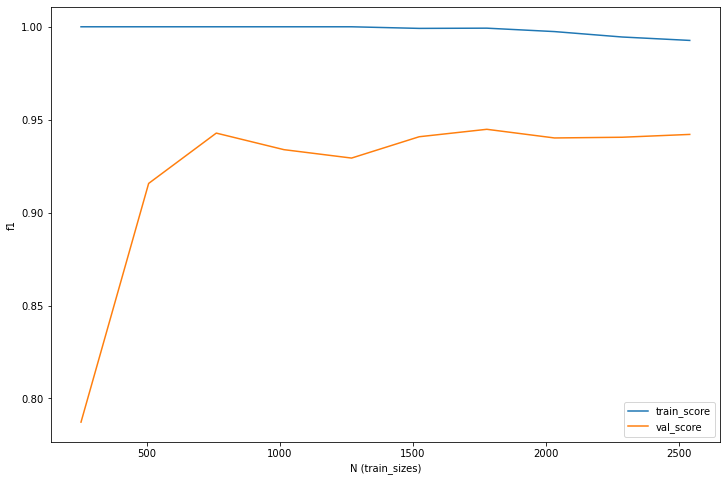

In [46]:
model_forest_pipeline = make_pipeline(SelectKBest(f_classif, k=5), RandomForestClassifier(random_state=0))

trainset, validset = train_test_split(covid, test_size=0.25, random_state=0)

X_train, y_train, imputer = preprocessing_knnimputer_train(trainset)
X_val, y_val = preprocessing_knnimputer_valid(validset)

evaluation(model_forest_pipeline,X_train,y_train,X_val,y_val) 

Analysis : with k=3, 
* the curves are quite the same as before.
* The 1-recall is slightly better. 

# Notes (attempts)

##  1
* preprocessing : .dropna()
* model : DecisionTreeClassifier()
* evaluation : 
    * confusion matrix
    * classification_report
    * learning_curves : scoring='f1'

Analysis :  
* there are not a lot of values after preprocessing
* y_val (validation target) proportions are not the same
* the model is overfitting (train_score 1, val_score <0.2).


## 2
* preprocessing : .fillna(), with an extreme value -999
* model : DecisionTreeClassifier()
* evaluation : idem
    
Analysis :  
* the number of values is better
* y_val proportions are now the same
* the 1-recall is really bad (6%), despite the 90% accuracy
* the scores are worse : 
    * we still have overfitting
    * moreover, 
        * it's not good even on the training set
        * val_score is worse (<0.1).
        
Other choices :  
* check with different imputation values : nothing really change on the learning curves 
* add a column 'is na' indicating some NaN :
    * 1st choice : use 'Platelets' and 'Leukocytes' (2 variables correlated to the target) 
    * 2d choice : use all the columns
    * no real improvement in both cases
    
    
## 3
* preprocessing : 
    * go back to .dropna()
    * features selection + .dropna()
* model : DecisionTreeClassifier
* evaluation : idem

Analysis : 
* The virus features seem to be useless : so let's get rid of these columns.
* as expected, we have this time more data after .dropna() 
* the model is still overfitting
* the val_score is very slightly better. 

## 4
* preprocessing : 
    * .dropna()
    * imputation with an extreme value =999
    * drop the virus columns + .dropna()
    * drop the virus columns + KNNImputer
* model : RandomForest()
* evaluation : idem  

Analysis : 
* 1st choice : really bad
* 2d choice : this model is worse at all levels
* 3d choice :
    * it's still not good, but the val_score seems to increase with N (train_sizes), maybe it could improve with more data
    * 'Platelets' and 'Leukocytes' are two main features, which is consistent with suspected in the EDA. 
* 4th choice :
    * **the val_score has increased significantly ! (0.94)**
    * **the 1-precision, 1-recall, f1-score are pretty good ! (0.96 / 0.87 / 0.91)**
    * we still have some overfitting.

## 5
* preprocessing : 
    * add a new feature 'virus_detected' + drop virus columns (except the new one) + KNNImputer()
* model : RandomForest (we try to improve the previous model)
* evaluation : idem

Analysis : 
* there is no real improvement
* it seems that there is a kind of cap after N=800.

## 6 
* preprocessing and model :
    * same preprocesing functions
    * make_pipeline + SelectKBest + RandomForest 
* evaluation : idem

Analysis : with k=3, 
* the curves are quite the same as before.
* The 1-recall is slightly better. 

NB : display problem with for loop on k ...

# Notes (some functions created + modifications)

* encoding 
* missing_data (modif x2)
* preprocessing_basic (modif x2; WARNING : .fit_transform for trainset but only .transform for validset !) 
* evaluation
* attempt (modif x1) 
    * NB : we could have modified this function in order to be able to modify the dataframe we use, after dropping some columns fro example)
* feature_engineering